In [15]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm import tqdm
%matplotlib inline

import time
from datetime import date, timedelta
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
# Import Subscription Data File
df = pd.read_csv('Subscription_Data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329489 entries, 0 to 329488
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   subscription_id     329489 non-null  int64 
 1   club_id             329489 non-null  int64 
 2   created             329489 non-null  object
 3   channel             329489 non-null  object
 4   subscription_start  329489 non-null  object
 5   subscription_end    329291 non-null  object
 6   total_billed        329489 non-null  int64 
 7   billing_rate        329489 non-null  int64 
 8   billing_cycle       329489 non-null  object
dtypes: int64(4), object(5)
memory usage: 22.6+ MB


In [6]:
# convert subscription date start and end to datetime
df['subscription_start']  = pd.to_datetime(df['subscription_start'] ,errors='coerce')
df['subscription_end']  = pd.to_datetime(df['subscription_end'] ,errors='coerce')

In [11]:
#Create Subscription length (days) Column (How long the user was subscribed)
df['subscription_length_days'] = (df['subscription_end'] - df['subscription_start']).dt.days

In [12]:
df.head()

,subscription_id,club_id,created,channel,subscription_start,subscription_end,total_billed,billing_rate,billing_cycle,subscription_length_days
0,1,98546,7/16/2020 11:46,WAP,2020-07-16 11:46:00,2020-07-16 11:49:00,0,3,DAILY,0.0
1,2,98546,7/16/2020 15:21,WAP,2020-07-16 15:21:00,2020-07-16 15:28:00,0,3,DAILY,0.0
2,3,98546,7/16/2020 15:35,WAP,2020-07-16 15:35:00,2020-08-13 12:33:00,975,3,DAILY,27.0
3,4,98546,7/17/2020 15:02,WAP,2020-07-17 15:02:00,2020-07-23 10:45:00,300,3,DAILY,5.0
4,5,98546,7/21/2020 12:16,WAP,2020-07-21 12:16:00,2020-07-21 12:28:00,0,3,DAILY,0.0


In [17]:
# Get average subscription duration and percentiles
# on average, subscribers stay 35 days with the services
# and on avergae they're are billed 623
df[['subscription_length_days','total_billed']].describe()

,subscription_length_days,total_billed
count,329291.000000,329489.000000
mean,35.498747,623.282795
std,30.157607,1844.991592
min,-1.000000,0.000000
25%,4.000000,0.000000
50%,30.000000,0.000000
75%,63.000000,375.000000
max,107.000000,29975.000000


<AxesSubplot:xlabel='subscription_length_days', ylabel='total_billed'>

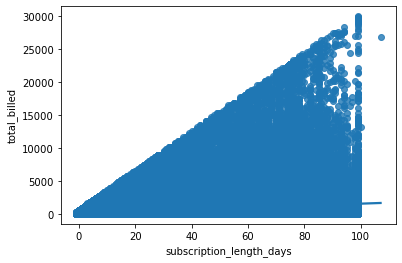

In [16]:
# see the relationship between length of the subsctiption and total billed
# the longer the subscription, obviously the longer the subscriber will be billed
sns.regplot(df.subscription_length_days, df.total_billed)

In [18]:
# Create score categories by binning the duration/length of the subscription using quintiles method.
# This method groups subscribers into 25% population based on their similarities of Subscription lenght and total billed.
# We create a varible called LS_TB (Lenght_subscription and Total Billed)
# This creates a score of 1-4 for each subscriber LS_TB  variable: 
          # 4- "Top Subscriber" being the subscriber who subscribed for longer and billed higher
         #  1 - "worst subscriber" - subscriber for few days and billed less
        

# Define Length subscription (LS) and Total Billed function to bin these variables
quintiles = df[['subscription_length_days', 'total_billed']].quantile([.25, .50, .75]).to_dict()
def LS(x):
    if x <= quintiles['subscription_length_days'][.25]:
        return 1
    elif x <= quintiles['subscription_length_days'][.50]:
        return 2
    elif x <= quintiles['subscription_length_days'][.75]:
        return 3
    else:
        return 4
    
    
def TB(x):
    if x <= quintiles['total_billed'][.25]:
        return 1
    elif x <= quintiles['total_billed'][.50]:
        return 2
    elif x <= quintiles['total_billed'][.75]:
        return 3
    else:
        return 4

In [21]:
# Appply the functions to the relevant variables
df['LS_Score'] = df['subscription_length_days'].apply(lambda x: LS(x))
df['TB_Score'] = df['total_billed'].apply(lambda x: TB(x))

# Create a LS_TB_Score which combines the score for LS and TB
df['LS_TB_Score'] = df['LS_Score'].map(str) + df['TB_Score'].map(str)
df['LS_TB_Score'] = df['LS_TB_Score'].astype(int)

In [22]:
"""
 A Subscriber with LS_TB Score of 11 would be 
"worst subscriber" since they have subscribed for a shorter period and also billed less"

Asubscriber with LS_TB_score of 44 is a Top subscriber since they have subscribed for longer and also billed higher
"""
df.head()

,subscription_id,club_id,created,channel,subscription_start,subscription_end,total_billed,billing_rate,billing_cycle,subscription_length_days,LS_Score,TB_Score,LS_TB_Score
0,1,98546,7/16/2020 11:46,WAP,2020-07-16 11:46:00,2020-07-16 11:49:00,0,3,DAILY,0.0,1,1,11
1,2,98546,7/16/2020 15:21,WAP,2020-07-16 15:21:00,2020-07-16 15:28:00,0,3,DAILY,0.0,1,1,11
2,3,98546,7/16/2020 15:35,WAP,2020-07-16 15:35:00,2020-08-13 12:33:00,975,3,DAILY,27.0,2,4,24
3,4,98546,7/17/2020 15:02,WAP,2020-07-17 15:02:00,2020-07-23 10:45:00,300,3,DAILY,5.0,2,3,23
4,5,98546,7/21/2020 12:16,WAP,2020-07-21 12:16:00,2020-07-21 12:28:00,0,3,DAILY,0.0,1,1,11


In [25]:
# Assign personalized names to subscribers based on their LS and TB scores

def ls_tb_segment(df):
    if ((df['LS_Score'] >= 3) and (df['TB_Score'] >= 3)):
        return 'Top Subscriber'
    elif ((df['LS_Score'] >=3) and (df['TB_Score'] < 3)):
        return 'Top Subscriber-Less Bill'
    elif ((df['LS_Score'] <3) and (df['TB_Score'] >= 3)):
        return 'Needs Attention'
    else:
        return 'Underperfoming'
    
# Create a new variable RFM_segment
df['LS_TB_segment'] = df.apply(ls_tb_segment, axis=1)
df.head()

,subscription_id,club_id,created,channel,subscription_start,subscription_end,total_billed,billing_rate,billing_cycle,subscription_length_days,LS_Score,TB_Score,LS_TB_Score,LS_TB_segment
0,1,98546,7/16/2020 11:46,WAP,2020-07-16 11:46:00,2020-07-16 11:49:00,0,3,DAILY,0.0,1,1,11,Underperfoming
1,2,98546,7/16/2020 15:21,WAP,2020-07-16 15:21:00,2020-07-16 15:28:00,0,3,DAILY,0.0,1,1,11,Underperfoming
2,3,98546,7/16/2020 15:35,WAP,2020-07-16 15:35:00,2020-08-13 12:33:00,975,3,DAILY,27.0,2,4,24,Needs Attention
3,4,98546,7/17/2020 15:02,WAP,2020-07-17 15:02:00,2020-07-23 10:45:00,300,3,DAILY,5.0,2,3,23,Needs Attention
4,5,98546,7/21/2020 12:16,WAP,2020-07-21 12:16:00,2020-07-21 12:28:00,0,3,DAILY,0.0,1,1,11,Underperfoming


#### Descriprion of the LS_TB Segments
- Needs Attention - these are subscribers who were billed high but they didn't stay long with the services they subscribed to. Finding ways to re-activate these sbscribers more profit to the business.
- Top Subscriber -  These are subscribers who stay long with the services they subscribed to and are also billed high. The are subscribers who are worth retaining as they're most profitable.
- Underperforming -  subscribers who don't spend long with their services and are also billed less
- Top Subscriber-Less Bill - these subscribers stay long with their subscriptions but they're billed less. It's worth finding strategies to get them subscribed to other content that appetize them to increase revenue

In [29]:
ls_tb_segment_agg = df.groupby('LS_TB_segment').agg({
    'total_billed': 'mean',
    'subscription_length_days': 'mean',
    'subscription_id': 'count',
}).round(1)
ls_tb_segment_agg

,total_billed,subscription_length_days,subscription_id
LS_TB_segment,,,
Needs Attention,1084.4,16.5,34951
Top Subscriber,1897.0,63.6,88278
Top Subscriber-Less Bill,0.0,60.9,76143
Underperfoming,0.0,6.7,130117


#### Observations

- The Top Subscriber are billed more than other subscribers (average 1897 billed) and they also spend longer on their subscriptions (average 63.6 days)
- The "Needs attention segment" are the second most billed but they do not spend long on their subscription (only average 16 days).
- Top Subscriber-Less Bill	- billed less but stay long with their sibscriptions
- Underperfoming - least billed and low duration on their subsctiptions

In [30]:
df.to_csv('df_sub.csv')